In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

## Helper functions


In [2]:
def sigmoid(z):
    a = 1/(1 + np.exp(-z))
    return a

def softmax(x): # X is a vector containing all the numbers
    a = np.exp(x) / np.sum(np.exp(x), axis = 0)
    return a

def L2loss(y, y_hat, n_samples):
        loss = (1/n_samples) * 0.5 * np.sum((y_hat - y)**2)
        loss = np.squeeze(loss)
        assert(loss.shape == ())
        return loss
    
def CatCrossEntropyLoss(y, y_hat, n_examples):
        loss = - (1/n_examples) * np.sum(y * np.log(y_hat))
        loss = np.squeeze(loss)
        assert(loss.shape == ())
        return loss
    
def evaluate(y_hat, y_real):    
    if y_hat.shape[0] == 1:
        y_new = y_hat > 0.5
        accuracy = np.mean(y_new == y_real)
        return accuracy
    else:
        y_new = np.argmax(y_hat, axis = 0)
        y_real = np.argmax(y_real, axis = 0)
        accuracy = np.mean(y_new == y_real)
        return accuracy
    
def predict(x, model):
    y_hat = model.forward(x, save = False)
    return y_hat

def one_hot_encoding(y, classes):
    y_hot = np.zeros((y.shape[0], classes))
    for i in range(0, len(y)):
        if y[i] == 0:
            y_hot[i, 0] = 1
        elif y[i] == 1:
            y_hot[i, 1] = 1
        elif y[i] == 2:
            y_hot[i, 2] = 1
    return y_hot
        
    
    

# Parameters handling

In [3]:
def initialize_parameters(layer1, layer2, classes, input_size):
    
    np.random.seed(1)
    
    W1 = np.random.randn(layer1, input_size) * 0.01
    b1 = np.zeros((layer1, 1))
    W2 = np.random.randn(layer2, layer1) * 0.01
    b2 = np.zeros((layer2, 1))
    W3 = np.random.randn(classes, layer2) * 0.01
    b3 = np.zeros((classes, 1))
    ### END CODE HERE ###
    
    assert(W1.shape == (layer1, input_size))
    assert(b1.shape == (layer1, 1))
    assert(W2.shape == (layer2, layer1))
    assert(b2.shape == (layer2, 1))
    assert(W3.shape == (classes, layer2))
    assert(b3.shape == (classes, 1))
    
    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3}
    
    return parameters

In [4]:
def update_parameters(learning_rate, model, decay):
    
        weights = model.weights # We import the weights 
        derivatives = model.derivatives
        (W1, b1, W2, b2, W3, b3) = (weights["W1"], weights["b1"], 
                                    weights["W2"], weights["b2"], 
                                    weights["W3"], weights["b3"])
        
        (dW1, db1, dW2, db2, dW3, db3) = (derivatives["dW1"], derivatives["db1"], 
                                          derivatives["dW2"], derivatives["db2"], 
                                          derivatives["dW3"], derivatives["db3"])

        
        assert(W1.shape == dW1.shape)
        assert(W2.shape == dW2.shape)
        assert(W3.shape == dW3.shape)
        
        W1 = W1 - learning_rate * (dW1 + decay * W1)
        b1 = b1 - learning_rate * (db1 + decay * b1)
        W2 = W2 - learning_rate * (dW2 + decay * W2)
        b2 = b2 - learning_rate * (db2 + decay * b2)
        W3 = W3 - learning_rate * (dW3 + decay * W3)
        b3 = b3 - learning_rate * (db3 + decay * b3)
        
        model.weights = {"W1": W1, "b1": b1,
                            "W2": W2, "b2": b2,
                            "W3": W3, "b3": b3}
        
    

## Classes for node types

In [5]:
class obj:

        
    def makeGraph(self,layer1, layer2, classes, input_size): # Takes as input the number of neurons per layer
        self.graph = []
        self.weights = initialize_parameters(layer1, layer2, classes, input_size)
        
        self.graph.append(MultiplyGate())
        self.graph.append(SigmoidGate())
        self.graph.append(MultiplyGate())
        self.graph.append(SigmoidGate())
        self.graph.append(MultiplyGate())
        self.graph.append(SoftmaxGate())

    
    def makeGraphBinary(self,layer1, layer2, classes, input_size): # Takes as input the number of neurons per layer
        self.graph = []
        self.weights = initialize_parameters(layer1, layer2, classes, input_size)
        
        self.graph.append(MultiplyGate())
        self.graph.append(SigmoidGate())
        self.graph.append(MultiplyGate())
        self.graph.append(SigmoidGate())
        self.graph.append(MultiplyGate())
        self.graph.append(SigmoidGate())

        
        

In [6]:
class MultiplyGate(obj):
    def forward(self, A, W, b, save):
        Z = np.dot(W, A) + b
        assert(Z.shape == (W.shape[0], A.shape[1]))
        if save == True:
            self.A = A # Stores x for backward pass
            self.W = W # Stores w for backward pass
            self.b = b
        return Z
    def backward(self,dZ, m):
        dW = (1/m) * np.dot(dZ , self.A.T)
        db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
        dZ = np.dot(self.W.T , dZ)

        assert (dZ.shape == self.A.shape)
        assert (dW.shape == self.W.shape)
        assert (db.shape == self.b.shape)

        return[dZ, dW, db]

    
class SigmoidGate(obj):
    def forward(self, x, save):
        z = sigmoid(x)
        if save == True:
            self.x = x
        return z
    def backward(self, dz):
        dx = (sigmoid(self.x)*(1 - sigmoid(self.x))) * dz
        return dx
    
    
class SoftmaxGate(obj):
    def forward(self, x):
        z = softmax(x)
        return z
    def backward(self, y, y_hat):
        dz = y_hat - y
        return dz
    



In [7]:
# ----------------------------------------------

class ComputeGraph(obj):
    
    def forward(self, inputs, save):
        
        weights = self.weights # We import the weights here

        (W1, b1, W2, b2, W3, b3) = (weights["W1"], weights["b1"], 
                                    weights["W2"], weights["b2"], 
                                    weights["W3"], weights["b3"])

        gate = self.graph[0] # Multiply gate input - 1st layer
        z = gate.forward(inputs, W1, b1, save)

        gate = self.graph[1] # Sigmoid gate
        z = gate.forward(z, save)
        
        gate = self.graph[2] # Multiply gate 1st - 2nd layer
        z = gate.forward(z, W2, b2, save)
        
        gate = self.graph[3] # sigmoid gate
        z = gate.forward(z, save)
        
        gate = self.graph[4] # Multiply gate 2nd - softmax layer
        z = gate.forward(z, W3, b3, save)
        
        gate = self.graph[5] # Softmax gate
        y_hat = gate.forward(z)
        
        return y_hat

    
    def backward(self, y, y_hat, m):
        
        self.derivatives = {}

        gate = self.graph[5] #Softmax Gate
        dz = gate.backward(y, y_hat)

        gate = self.graph[4] # Multiply gate 2nd - softmax layer
        (dz, dW3, db3) = gate.backward(dz, m)

        gate = self.graph[3] # Sigmoid Gate
        dz = gate.backward(dz)

        gate = self.graph[2] # Multiply gate 2nd - 1st layer
        (dz, dW2, db2) = gate.backward(dz, m)

        gate = self.graph[1] # Sigmoid gate
        dz = gate.backward(dz)

        gate = self.graph[0] # Multiply gate input - 1st layer
        (dz, dW1, db1) = gate.backward(dz, m)

        self.derivatives = {"dW1" : dW1, "db1" : db1,
                            "dW2" : dW2, "db2" : db2,
                            "dW3" : dW3, "db3" : db3}
        
        return  self.derivatives

In [8]:
def ComputeModel(model, input_vector, output_vector, x_val, y_val, batch_size, epochs, learning_rate, decay):
    
    np.random.seed(1)
    n_samples = input_vector.shape[1]
    n_batches = n_samples // batch_size
    batches_input = []
    batches_output = []
    loss = []
    loss_val = []
    
    
    
    # Create the batches
    for i in range(0, n_batches):
        batches_input.append(input_vector[:, (i*batch_size):((i+1)*batch_size)])
        
        if (output_vector.shape[0] == 1):
            batches_output.append(output_vector[:, (i*batch_size):((i+1)*batch_size)])
        else:
            batches_output.append(output_vector[:, (i*batch_size):((i+1)*batch_size)])
            
    if (n_samples % batch_size != 0):
        batches_input.append(input_vector[:, (i+1)*batch_size:])
        if (output_vector.shape[0] == 1):
            batches_output.append(output_vector[:, (i+1)*batch_size:])
        else:
            batches_output.append(output_vector[:, (i+1)*batch_size:])
        n_batches += 1
    
    for i in range(0, epochs):
        
        loss_batch = []
        loss_val_batch = []
        
        for i in range(0, n_batches):
            save = True # This parameter is needed to do the validation part
            
            x = batches_input[i]
            y = batches_output[i]
            
            y_hat = model.forward(x, save)
            loss_batch.append(CatCrossEntropyLoss(y, y_hat, x.shape[1]))
            

            assert(y.shape == y_hat.shape)

            
            derivatives = model.backward(y, y_hat, x.shape[1])
            update_parameters(learning_rate, model, decay)
            
            save = False # We don't want the new parameters saved for the validation
             
            y_hat_val = model.forward(x_val, save)
            loss_val_batch.append(CatCrossEntropyLoss(y_val, y_hat_val, x_val.shape[1]))

        
        loss.append(np.sum(loss_batch) / len(loss_batch))   
        loss_val.append(np.sum(loss_val_batch) / len(loss_val_batch))
        
    # plot the cost

    plt.plot(np.squeeze(loss), label = 'Training loss')
    plt.plot(np.squeeze(loss_val), label = 'Validation loss')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.title("Cost per epoch with Learning rate =" + str(learning_rate))
    plt.legend()
    plt.show()
    
    return loss
            
    
    

# Import  train and evaluate dataset from UCI

In [9]:
def to_cat(y):
    for i in range(0,len(y)):
        if (y[i] == 'Dendrobatidae'):
            y[i] = 0
        elif (y[i] == 'Hylidae'):
            y[i] = 1
        elif (y[i] == 'Leptodactylidae'):
            y[i] = 2
    return y

In [10]:
def load_dataset1():

    df_frogs = pd.read_csv('./Frogs_MFCCs.csv')
    x = df_frogs.iloc[:, 0:22].to_numpy()
    y = df_frogs['Family'].to_numpy()
    mask_train = ((y == 'Dendrobatidae') + (y == 'Hylidae') + (y == 'Leptodactylidae'))
    y = y[mask_train]
    x = x[mask_train]
    mean = x.mean(axis = 0)
    x -= mean
    std = x.std(axis = 0)
    x /= std
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    
    y_train = to_cat(y_train)
    y_train = one_hot_encoding(y_train, 3)
    y_test = to_cat(y_test)
    y_test = one_hot_encoding(y_test, 3)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

    return (x_train.T, x_test.T, x_val.T, y_train.T, y_test.T, y_val.T)

In [11]:
x_train, x_test, x_val, y_train, y_test, y_val = load_dataset1()

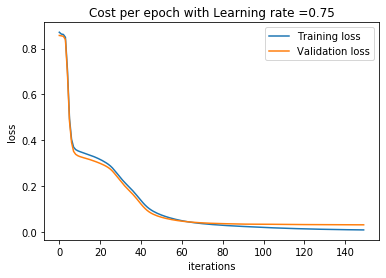

In [12]:
model = ComputeGraph()
model.makeGraph(20, 10, 3, x_train.shape[0])
loss = ComputeModel(model, x_train, y_train, x_val, y_val, batch_size = 128, epochs = 150, learning_rate = 0.75, decay = 0.0001)

In [13]:
y_hat = predict(x_test, model)
evaluate(y_hat, y_test)

0.9908835904628331

In [14]:
import pickle
filename = 'Frogs_model.sav'
pickle.dump(model, open(filename, 'wb')) # save model

In [15]:
model = pickle.load(open(filename, 'rb')) # import model

# Import train and evaluate another dataset from UCI

In [16]:
def modify(y):
    for i in range(0,len(y)):
        if y[i] == 5:
            y[i] = 0
        elif y[i] == 6:
            y[i] = 1
        elif y[i] == 7:
            y[i] = 2
    return y

In [17]:
def load_dataset2():
    df = pd.read_csv('./winequality-white.csv', sep = ';')
    x = df.iloc[:, 0:11].to_numpy()
    y = df['quality'].to_numpy()
    mask = ((y == 5) + (y == 6) + (y == 7))
    x = x[mask]
    y = y[mask]
    mean = x.mean(axis = 0)
    x -= mean
    std = x.std(axis = 0)
    x /= std
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    y_train = modify(y_train)
    y_train = one_hot_encoding(y_train, 3)
    y_test = modify(y_test)
    y_test = one_hot_encoding(y_test, 3)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
    
    return (x_train.T, x_test.T, x_val.T, y_train.T, y_test.T, y_val.T)

In [18]:
x_train, x_test, x_val, y_train, y_test, y_val = load_dataset2()

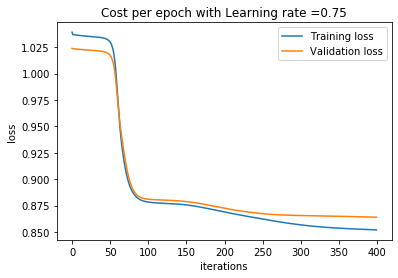

In [19]:
model = ComputeGraph()
model.makeGraph(15, 10, 3, x_train.shape[0])
loss = ComputeModel(model, x_train, y_train, x_val, y_val, batch_size = 256, epochs = 400, learning_rate = 0.75, decay = 0.001)

In [20]:
y_hat = predict(x_test, model)
evaluate(y_hat, y_test)

0.5755237045203969

In [21]:
import pickle
filename = 'wine_model.sav'
pickle.dump(model, open(filename, 'wb')) # save model

In [22]:
model = pickle.load(open(filename, 'rb')) # import model